In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

%matplotlib inline

/Users/garylau/anaconda/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
#load data
bank = pd.read_csv('bank-additional/bank-additional-full.csv',delimiter=(';'))

# Introduction

The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. 
The classification goal is to predict if the client will subscribe a term deposit (variable y).

There are 41188 records and 21 variables in our data set. 

Below is a sample of the data.

In [3]:
#checking of dataframe shape and variables
print("The dimention of the data is: ", bank.shape)
print("List of variables: ", [i for i in bank.columns])
print("Number of missing value: ", bank.isnull().values.sum())

The dimention of the data is:  (41188, 21)
List of variables:  ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']
Number of missing value:  0


In [4]:
print("Sample data: ")
bank.head()

Sample data: 


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Data Preoprocessing
## Reponse variables : y
Firstly, we check the class in y.

In [5]:
bank.groupby("y").size()

y
no     36548
yes     4640
dtype: int64

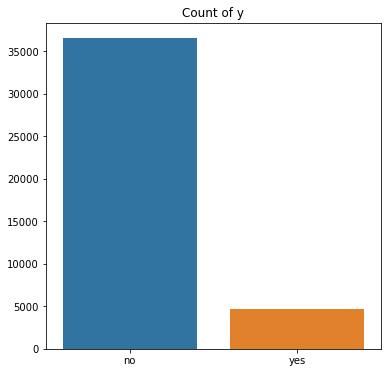

In [6]:
plt.figure(1, figsize=(6, 6))
x = [classes for classes in bank.groupby('y').count().index]
y = [count for count in bank.groupby('y').count()['age'].values]
sns.barplot(x, y)
plt.title('Count of y')
plt.show()

The response variable y is severly imbalanced. As this will affect the accuracy of the model built by the algorithm, the minority class (yes) will be upsized to match the majority class (no).

In [7]:
from sklearn.utils import resample
# Separate majority and minority classes
majority = bank[bank.y=='no']
minority = bank[bank.y=='yes']
 
# Downsample majority class
resample = resample(minority, 
                    replace=True,    # sample without replacement
                    n_samples=36548,     # to match minority class
                    random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
bank_n = pd.concat([resample, majority])
 
# Display new class counts
print("The processed dataset has response as follow: ")
print(bank_n.y.value_counts())

The processed dataset has response as follow: 
no     36548
yes    36548
Name: y, dtype: int64


## Categorical Variables

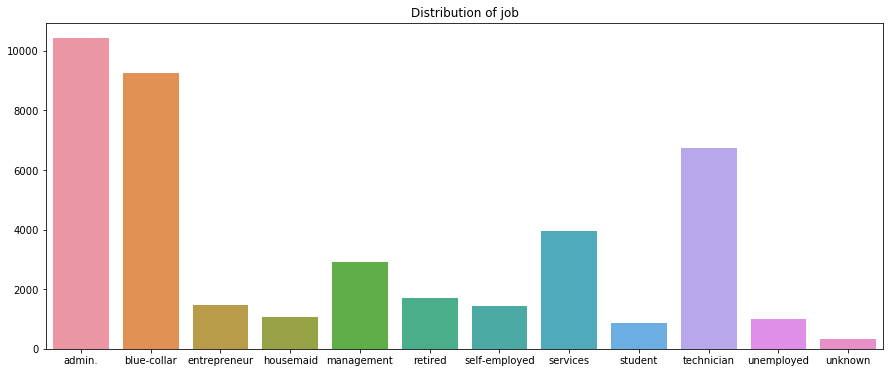

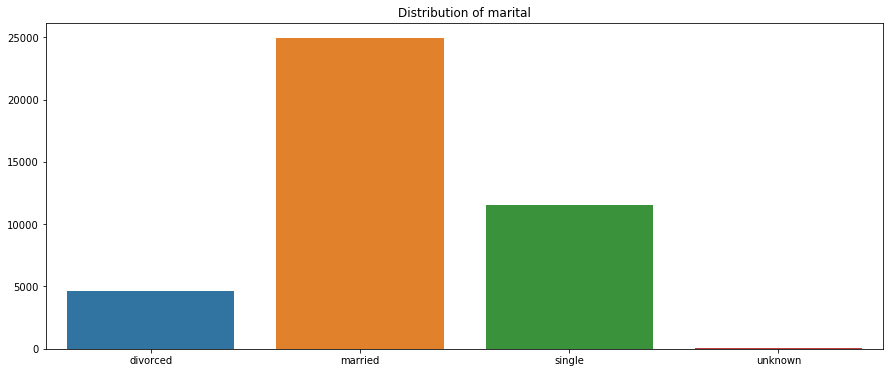

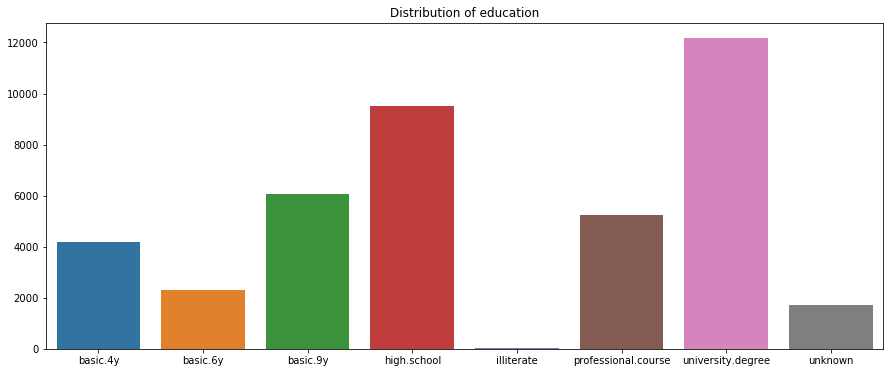

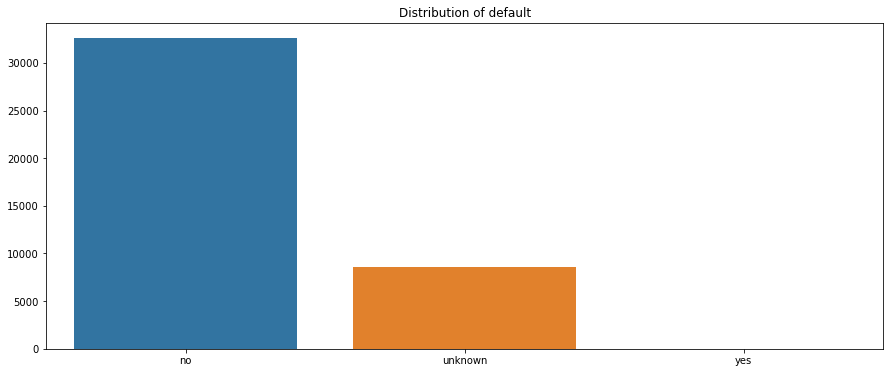

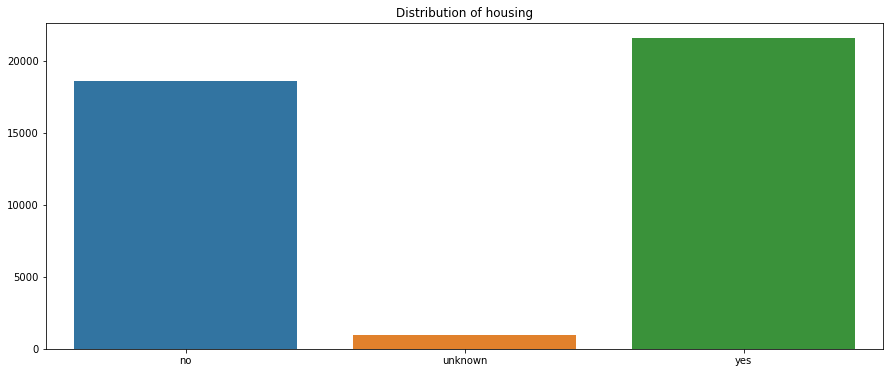

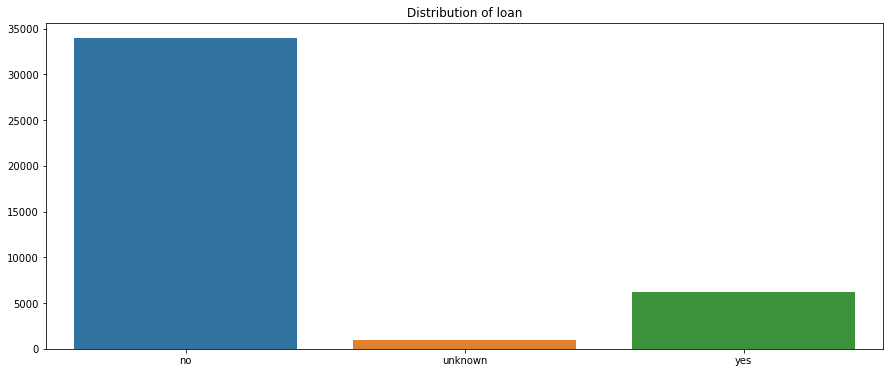

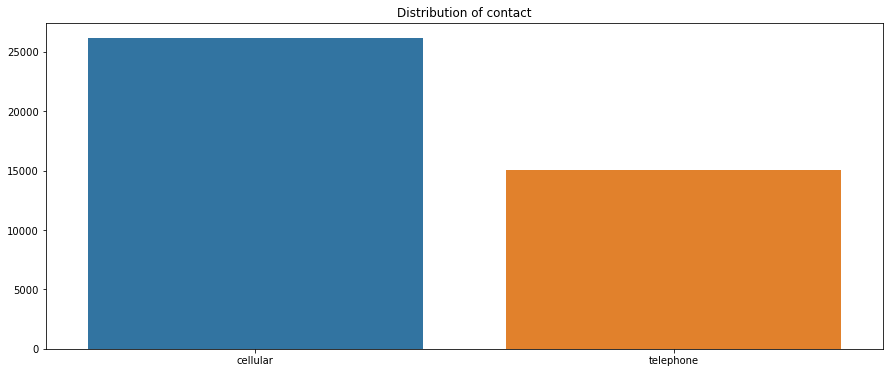

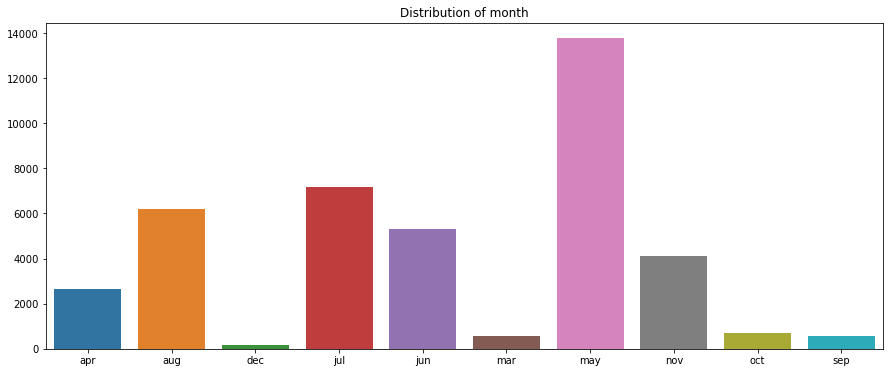

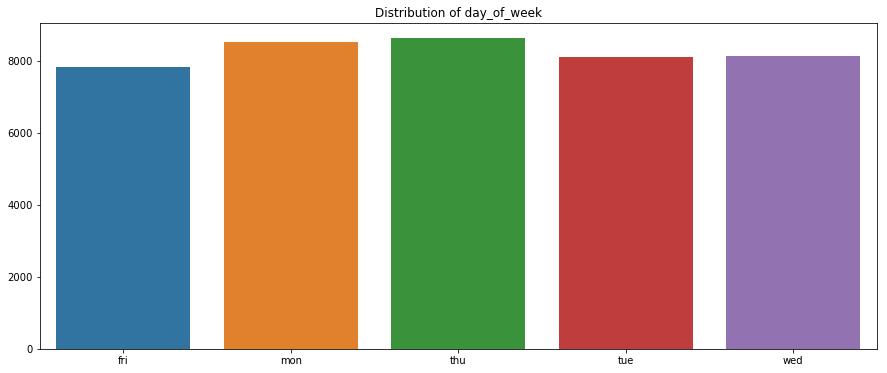

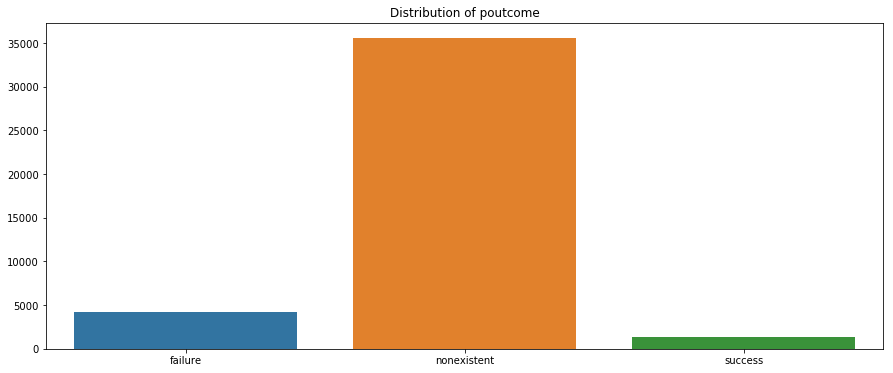

In [8]:
cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',  'poutcome']

for i in range(0,len(cat)):
    plt.figure(1, figsize=(15, 6))
    x = [classes for classes in bank.groupby(cat[i]).count()['y'].index]
    y = [count for count in bank.groupby(cat[i]).count()['y'].values]
    sns.barplot(x, y)
    plt.title('Distribution of %s'%cat[i])
    plt.show()

Above is list of the predictors and number of observations among their classes. 

As shown, most clients do not know if they have credit in default and only very few know they has credit as default. This variable may not provide if having credit in default influenced the result class in our model. Hence, $\textbf{default}$ will be drop.

To simplify some of our variables, we will also group some of the low frequency classes:

- $\textbf{marital}$ : "unknown" is grouped with "single"
- $\textbf{education}$ : "illiterate" is grouped with "basic.4y" to a new class "<basic.4y"
- $\textbf{housing}$ : "unknown" is grouped with "no"
- $\textbf{loan}$ : "unknown" is grouped with "no"



In [9]:
#Data manipulation
#default
bank_n = bank_n.drop('default',axis=1)

#marital
bank_n.marital[bank_n.marital =='unknown']['marital'] = 'single'

#education
bank_n.education[bank_n.education == 'illiterate']['education'] = '<basic.4y'
bank_n.education[bank_n.education == 'basic.4y']['education'] = '<basic.4y'

#housing
bank_n.housing[bank_n.housing =='unknown']['housing'] = 'no'

#loan
bank_n.loan[bank_n.loan =='unknown']['loan'] = 'no'


According to $\textbf{pdays}$, over 90% customers has not been contacted before this campaign. Instead of considering the days different from previous contact, we are more insterested in whether the customer has been contacted or not. Hence, new categorical variable  $\textbf{precon}$. is created to indicate whether the client has been contacted (no/yes) within a year(365 days) based on $\textbf{pdays}$.

In [10]:
#convert pdays to new variable precon
bank_n.loc[bank_n['pdays'] ==999 , 'precon'] = 'no'
bank_n.loc[bank_n['pdays'] !=999 , 'precon'] = 'yes'
bank_n = bank_n.drop('pdays',axis=1)

# Continuous Variables

In this section, we explored the distribution of the continuous varaibles. Below is the statistical summary of all the continuous prectictors.

In [11]:
cont_var = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m','nr.employed'] 
bank_n.describe()

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,73096.000000,73096.000000,73096.000000,73096.000000,73096.000000,73096.000000,73096.000000,73096.000000,73096.000000
mean,40.360690,387.648257,2.343001,0.312644,-0.491941,93.478330,-40.216186,2.967535,5135.768637
std,11.975303,361.616524,2.368039,0.697941,1.721887,0.633032,5.348951,1.889335,86.819671
min,17.000000,0.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,31.000000,144.000000,1.000000,0.000000,-1.800000,92.893000,-42.700000,1.244000,5076.200000
50%,38.000000,266.000000,2.000000,0.000000,-0.100000,93.444000,-41.800000,4.021000,5191.000000
75%,48.000000,526.000000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.959000,5228.100000
max,98.000000,4918.000000,56.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


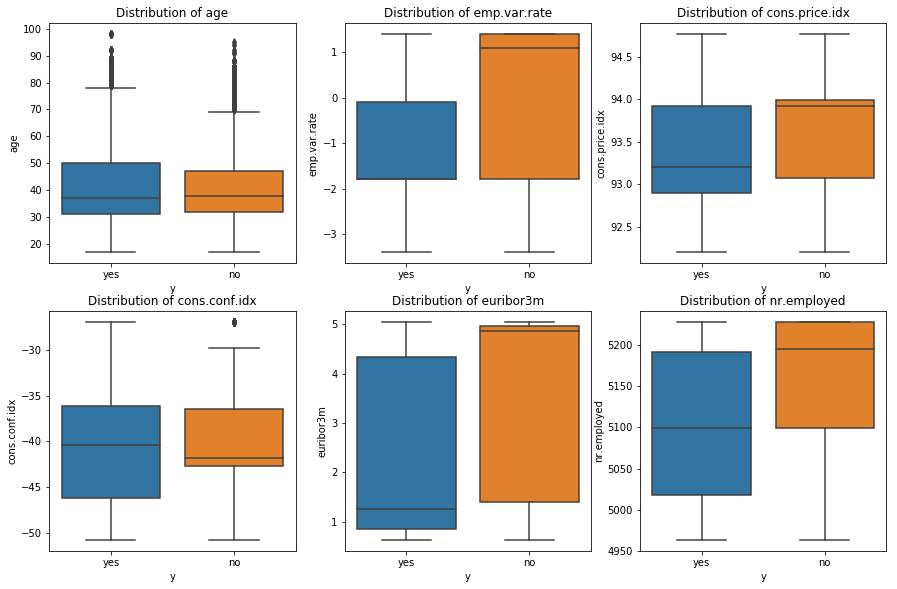

In [12]:
plt.figure(1, figsize=(15, 15))
for i in range(0,len(cont_var)):
    plt.subplot(331+i)
    sns.boxplot(bank_n['y'],bank_n[cont_var[i]])
    plt.title('Distribution of %s'%cont_var[i])
plt.show()


From the box plots, only $\textbf{emp.var.rate}$, $\textbf{euribor3m}$ and $\textbf{nr.employ}$ shows different median in the two target class. However, the variation of these variables is huge, this may indicate these variables are not signifiacant for classifying the target.

# Class Labelling

To create an input for the machine learning algorithm, all the variables is encoeded into categorical variables and sample of the data is show below.

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
bank_n = bank_n.apply(le.fit_transform)
bank_n.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,precon
39152,16,0,1,6,2,0,0,5,4,235,2,1,2,3,12,18,18,2,1,1
38893,31,4,1,6,2,2,0,7,3,747,1,0,1,0,4,23,47,3,1,0
27708,11,9,2,6,2,0,0,5,1,120,2,0,1,3,7,1,254,6,1,0
40048,29,0,1,3,2,2,0,3,3,396,0,2,2,4,22,11,93,1,1,1
28676,15,1,1,2,0,0,0,0,2,583,0,1,2,3,10,3,223,6,1,1


# Model Building

In [14]:
#split the data
from sklearn.model_selection import train_test_split
from Profolio3_ext import model_evaluation_score, model_evaluation_plot, random_seed_check, evaluate_score_plot#a external function used to produce evaluation result

#data = bank_n[predictors].drop(cont_var,axis=1) 
data = bank_n[bank_n.columns.drop('y')]
target = bank_n['y']
random_seed = [10, 20, 30, 40, 50, 60, 70, 80, 90,100]
train_size = 0.7
test_size =0.3

## Gaussian Naive Bayes

In [15]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

#generate evaluation of different random seed
result = random_seed_check(clf, data, target, random_seed,train_size, test_size)
result

,test_acc,test_auc,train_acc,train_auc
10,0.761275,0.867612,0.759884,0.867284
20,0.761001,0.869408,0.760627,0.866124
30,0.759314,0.867408,0.761585,0.866743
40,0.758585,0.860188,0.761761,0.868419
50,0.758083,0.865379,0.761096,0.867244
60,0.759770,0.867978,0.759396,0.865843
70,0.762278,0.868384,0.759962,0.866459
80,0.759725,0.865205,0.763129,0.868240
90,0.762050,0.868510,0.760099,0.867062
100,0.762096,0.867201,0.759376,0.866108


In [16]:
result.describe()

,test_acc,test_auc,train_acc,train_auc
count,10.000000,10.000000,10.000000,10.000000
mean,0.760418,0.866727,0.760691,0.866953
std,0.001526,0.002647,0.001201,0.000878
min,0.758083,0.860188,0.759376,0.865843
25%,0.759417,0.865834,0.759904,0.866207
50%,0.760386,0.867510,0.760363,0.866903
75%,0.761856,0.868283,0.761462,0.867274
max,0.762278,0.869408,0.763129,0.868419


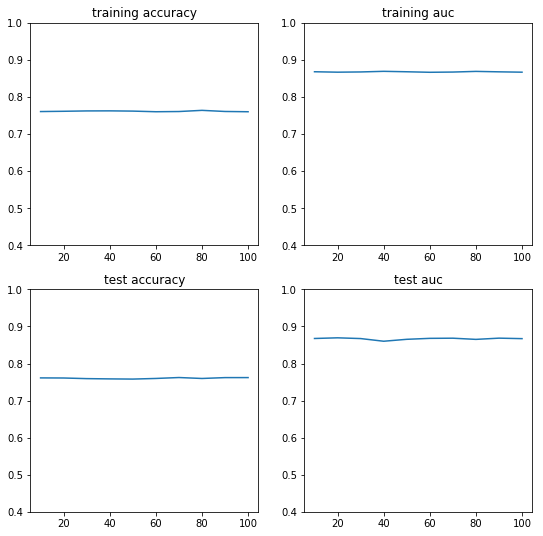

In [17]:
evaluate_score_plot(random_seed, result)

Running the model with 10 different random seeds, the average accuracy rate for training data and test data in Gaussian Naive Bayes Model is around 0.76 and the AUC is around 0.87. As the acccuracy and AUC are both similar in test and training data, the model is stable.

## Multinomial Naive Bayes

In [18]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()

#generate evaluation of different random seed
result1 = random_seed_check(mnb, data, target, random_seed,train_size, test_size)
result1

,test_acc,test_auc,train_acc,train_auc
10,0.824023,0.891762,0.825806,0.895546
20,0.825710,0.895769,0.824789,0.894047
30,0.824798,0.893862,0.825239,0.894874
40,0.822792,0.892892,0.826627,0.895200
50,0.827033,0.895186,0.824242,0.894327
60,0.827762,0.896919,0.824066,0.893861
70,0.823157,0.893353,0.826040,0.894967
80,0.823385,0.891935,0.825747,0.895563
90,0.822473,0.893835,0.826275,0.894897
100,0.824889,0.894603,0.825278,0.894579


In [19]:
result1.describe()

,test_acc,test_auc,train_acc,train_auc
count,10.000000,10.000000,10.000000,10.000000
mean,0.824602,0.894011,0.825411,0.894786
std,0.001794,0.001646,0.000850,0.000583
min,0.822473,0.891762,0.824066,0.893861
25%,0.823214,0.893007,0.824902,0.894390
50%,0.824411,0.893848,0.825513,0.894886
75%,0.825505,0.895040,0.825982,0.895142
max,0.827762,0.896919,0.826627,0.895563


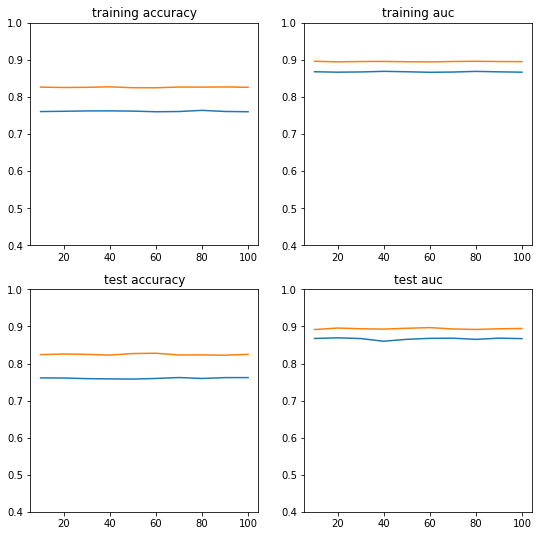

In [20]:
evaluate_score_plot(random_seed, result, result1)

Running the model with 10 different random seeds, the average accuracy rate for training data and test data in Multinomial Naive Bayes Model is around 0.83 and the AUC is around 0.89. As the acccuracy and AUC are both similar in test and training data, the model is stable.

From the graph, we can see accuracy and auc (orange line) from Multinomial Naive Bayes model is consistently higher than those from the Gaussian Naive Bayes model. Hence, the Multinomial Naive Bayes model has a better performance in classifying the target.

# Discretization

In [21]:
from sklearn.preprocessing import KBinsDiscretizer

kbin = KBinsDiscretizer(n_bins=5, encode='onehot', strategy='uniform')
data_trans = kbin.fit_transform(data)

#generate evaluation of different random seed
result2 = random_seed_check(mnb, data_trans, target, random_seed,train_size, test_size)
result2

,test_acc,test_auc,train_acc,train_auc
10,0.750331,0.863437,0.750992,0.863162
20,0.749373,0.865774,0.747396,0.861757
30,0.749555,0.863038,0.749272,0.862841
40,0.739614,0.856797,0.750151,0.865132
50,0.748598,0.861343,0.747239,0.863498
60,0.751015,0.862389,0.750972,0.862958
70,0.751288,0.863810,0.748803,0.862478
80,0.743262,0.862676,0.747826,0.863012
90,0.755392,0.865926,0.750191,0.862080
100,0.749236,0.862620,0.748881,0.862724


In [22]:
result2.describe()

,test_acc,test_auc,train_acc,train_auc
count,10.000000,10.000000,10.000000,10.000000
mean,0.748766,0.862781,0.749172,0.862964
std,0.004385,0.002549,0.001394,0.000917
min,0.739614,0.856797,0.747239,0.861757
25%,0.748757,0.862447,0.748070,0.862540
50%,0.749464,0.862857,0.749077,0.862900
75%,0.750844,0.863717,0.750181,0.863124
max,0.755392,0.865926,0.750992,0.865132


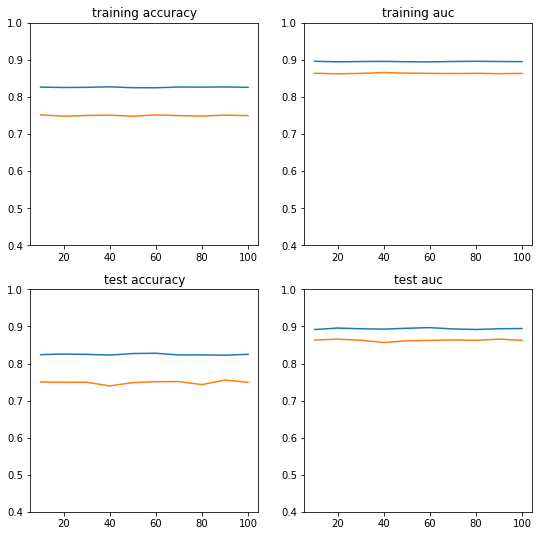

In [23]:
evaluate_score_plot(random_seed, result1, result2)

We have splited the continuous data into 5 bins with uniform witdth. The accuracy for both training and testing data is around 0.75 and Auc is around 0.86. When we compare the performance of the model without discretization, the classification is less accurate. This may becasue information is lost when data,especial continuous variables, is dicretized into groups.

# Feature Selection

In [24]:
from sklearn.feature_selection import RFE
r = 10
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=r, train_size=train_size, test_size = test_size)
mnb = MultinomialNB()

#initial list to store the evaluation results
train_acc = []
train_auc = []
test_acc = []
test_auc = []
no_of_features =range(1,data.shape[1]+1)

#itereation on increasing number of features from 1 to Max
for features in no_of_features:
    rfe = RFE(estimator=mnb, n_features_to_select=features, step=1)
    rfe.fit(X_train, y_train)
        
        
    #generate a dictionary of result (see function def in Porfoio 3)
    evaluation = model_evaluation_score(rfe, X_train, X_test, y_train, y_test)
        
    #store result
    train_acc.append(evaluation['train_acc'])
    train_auc.append(evaluation['train_auc'])
    test_acc.append(evaluation['test_acc'])
    test_auc.append(evaluation['test_auc'])


#create data frame
result = pd.DataFrame({'train_acc':train_acc,'train_auc': train_auc,'test_acc':test_acc, 'test_auc':test_auc},index=no_of_features)

result

,test_acc,test_auc,train_acc,train_auc
1,0.499384,0.500000,0.500264,0.500000
2,0.625975,0.684528,0.617253,0.675004
3,0.625975,0.683339,0.617253,0.673035
4,0.623786,0.687730,0.616511,0.679805
5,0.631994,0.693432,0.625833,0.684909
6,0.632085,0.694058,0.625735,0.686590
7,0.632085,0.688208,0.625735,0.681519
8,0.632131,0.692331,0.625735,0.685405
9,0.632131,0.692232,0.625735,0.685422
10,0.632633,0.691111,0.627690,0.683467


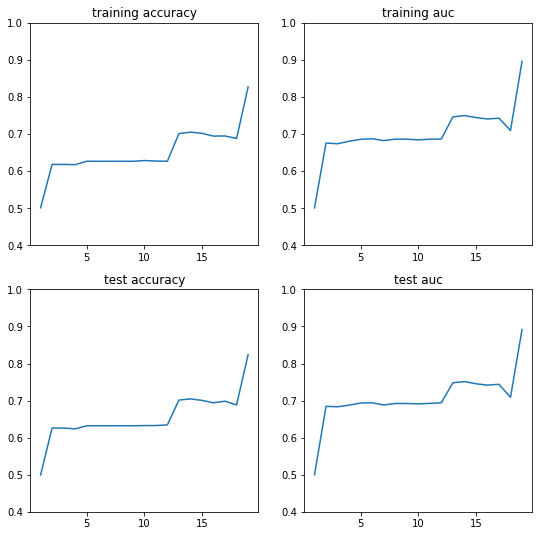

In [25]:
evaluate_score_plot(no_of_features, result, compare = None)

We can see the accuracy and auc both shown an increasing staircase function. As the number of features in the model increase, both accuracy and auc increased. This is because the more features the more information about the sample is being captured by the model.  Below is the rank of the importance of the features in the data.

In [26]:
rfe = RFE(estimator=mnb, n_features_to_select=1, step=1)
rfe.fit(X_train, y_train)
ranking = {}
for i in range(0,len(data.columns)):
    ranking[data.columns[i]] = rfe.ranking_[i]
print("decending importance of features: ")
sorted(ranking, key=ranking.__getitem__)

decending importance of features: 


['contact',
 'precon',
 'loan',
 'previous',
 'campaign',
 'poutcome',
 'housing',
 'marital',
 'day_of_week',
 'job',
 'education',
 'month',
 'emp.var.rate',
 'nr.employed',
 'cons.conf.idx',
 'cons.price.idx',
 'age',
 'euribor3m',
 'duration']

# Extention

Based on the feedback, I will further investigate if the resampling I did was unreliable. I will also try other technique counter the unbalanced response to see which method work better. The technique is picked based on an article from KDnuggets

https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html

To test if the resampling is reliable, the data will be set to 3 groups: train, test and evaluate which resampling will only be done on the train and test data. And use the evaluate data to check the result.

And by comparing the the accuracy and AUC on the test is still stable, hence, oversampling and downsampling on this data set is suitable.

In [27]:
bank_e = bank
#Data manipulation
#default
bank_e = bank_e.drop('default',axis=1)

#marital
bank_e.marital[bank_e.marital =='unknown']['marital'] = 'single'

#education
bank_e.education[bank_e.education == 'illiterate']['education'] = '<basic.4y'
bank_e.education[bank_e.education == 'basic.4y']['education'] = '<basic.4y'

#housing
bank_e.housing[bank_e.housing =='unknown']['housing'] = 'no'

#loan
bank_e.loan[bank_e.loan =='unknown']['loan'] = 'no'

#code the 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
bank_e = bank_e.apply(le.fit_transform)
bank_e.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,39,3,1,0,0,0,1,6,1,261,0,26,0,1,8,18,16,287,8,0
1,40,7,1,3,0,0,1,6,1,149,0,26,0,1,8,18,16,287,8,0
2,20,7,1,3,2,0,1,6,1,226,0,26,0,1,8,18,16,287,8,0
3,23,0,1,1,0,0,1,6,1,151,0,26,0,1,8,18,16,287,8,0
4,39,7,1,3,0,2,1,6,1,307,0,26,0,1,8,18,16,287,8,0


In [28]:
data = bank_e[bank_e.columns.drop('y')]
target = bank_e['y']
X, X_test, y, y_test = train_test_split(data, target, random_state=123, train_size=0.8, test_size = 0.2)
bank_t = pd.concat([X,y],axis=1)

In [29]:
bank_t.groupby('y').count()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,,,,,,,,,,
0,29250,29250,29250,29250,29250,29250,29250,29250,29250,29250,29250,29250,29250,29250,29250,29250,29250,29250,29250
1,3700,3700,3700,3700,3700,3700,3700,3700,3700,3700,3700,3700,3700,3700,3700,3700,3700,3700,3700


## Oversampling

In [30]:
from sklearn.utils import resample
# Separate majority and minority classes
majority = bank_t[bank_t.y==0]
minority = bank_t[bank_t.y==1]
 
# Downsample majority class
resample = resample(minority, 
                    replace=True,    # sample without replacement
                    n_samples=29250,     # to match minority class
                    random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
bank_n = pd.concat([resample, majority])
 
# Display new class counts
print("The processed dataset has response as follow: ")
print(bank_n.y.value_counts())

The processed dataset has response as follow: 
1    29250
0    29250
Name: y, dtype: int64


In [31]:
data = bank_n[bank_n.columns.drop('y')]
target = bank_n['y']
X_train, X_valid, y_train, y_valid = train_test_split(data, target, random_state=123, train_size=0.8, test_size = 0.2)

In [32]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
model_performance = model_evaluation_score(mnb, X_train, X_valid, y_train, y_valid)

In [33]:
from sklearn.metrics import accuracy_score, auc, roc_auc_score
predicted = mnb.predict(X_test)
y_score = mnb.predict_proba(X_test)[:,1]
eva_acc = accuracy_score(y_test,predicted)
eva_auc = roc_auc_score(y_test,y_score )
model_performance['eva_acc'] = eva_acc
model_performance['eva_auc'] = eva_auc
model_performance

{'eva_acc': 0.84620053411022089,
 'eva_auc': 0.89769625021136656,
 'test_acc': 0.82358974358974357,
 'test_auc': 0.89532360892391682,
 'train_acc': 0.82032051282051277,
 'train_auc': 0.89104290532674679}

The result show similar AUC and ACC across all test, evaluate and test data which means the model is stable.

## Downsampling

In [34]:
from sklearn.utils import resample
# Separate majority and minority classes
majority = bank_t[bank_t.y==0]
minority = bank_t[bank_t.y==1]
 
# Downsample majority class
resample = resample(majority, 
                    replace=True,    # sample without replacement
                    n_samples=3700,     # to match minority class
                    random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
bank_n = pd.concat([resample, minority])
 
# Display new class counts
print("The processed dataset has response as follow: ")
print(bank_n.y.value_counts())

The processed dataset has response as follow: 
1    3700
0    3700
Name: y, dtype: int64


In [35]:
data = bank_n[bank_n.columns.drop('y')]
target = bank_n['y']
X_train, X_valid, y_train, y_valid = train_test_split(data, target, random_state=123, train_size=0.8, test_size = 0.2)

In [36]:
mnb = MultinomialNB()
mnb.fit(X_train,y_train)
model_performance = model_evaluation_score(mnb, X_train, X_valid, y_train, y_valid)

In [37]:
from sklearn.metrics import accuracy_score, auc, roc_auc_score
predicted = mnb.predict(X_test)
y_score = mnb.predict_proba(X_test)[:,1]
eva_acc = accuracy_score(y_test,predicted)
eva_auc = roc_auc_score(y_test,y_score )
model_performance['eva_acc'] = eva_acc
model_performance['eva_auc'] = eva_auc
model_performance

{'eva_acc': 0.84450109249817917,
 'eva_auc': 0.89696426593120826,
 'test_acc': 0.83513513513513515,
 'test_auc': 0.89821117980648357,
 'train_acc': 0.82128378378378375,
 'train_auc': 0.88804017968019511}

Similarly, the result show similar AUC and ACC across all test, evaluate and test data which means the model is stable.

## K-fold Validation

We use K-fold validation to check the change of accuracy rate if the model is build with the original data.

In [38]:
from sklearn.model_selection import cross_val_score
mnb = MultinomialNB()
cross_val_score(mnb, X, y, cv=5)

array([ 0.84066768,  0.84764795,  0.84946889,  0.84430956,  0.84977238])

In [39]:
from sklearn.metrics import confusion_matrix
mnb.fit(X,y)
y_pred = mnb.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[6226, 1072],
       [ 185,  755]])

In [40]:
predicted = mnb.predict(X_test)
y_score = mnb.predict_proba(X_test)[:,1]
eva_acc = accuracy_score(y_test,predicted)
eva_auc = roc_auc_score(y_test,y_score )
print(eva_acc,eva_auc) 

0.847414420976 0.897834513099


The data show high train and test score even without resampling the data so we cannot tell if the technique helped to improve the result of our model in this case.